In [35]:
# Import necessary dependencies
import sys
import os
import zipfile

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

# Get the current working directory
current_dir = os.getcwd()

# Project directory
project_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
sys.path.append(project_dir)

# Python file for custom functions
from src.utils import *

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [36]:
# Directory to your zipfile
ZIPFILE_PATH = os.path.join(project_dir, 'datasets', 'ICPSR_38925-V1.zip')

# Directories to the parquet files
DS0001 = os.path.join(project_dir, 'datasets', 'ICPSR_38925/batch_header_extract_ds0001.parquet')
DS0002 = os.path.join(project_dir, 'datasets', 'ICPSR_38925/admin_extract_ds0002.parquet')
DS0003 = os.path.join(project_dir, 'datasets', 'ICPSR_38925/incident_extract_ds0003.parquet')
DS0004 = os.path.join(project_dir, 'datasets', 'ICPSR_38925/victim_extract_ds0004.parquet')
DS0005 = os.path.join(project_dir, 'datasets', 'ICPSR_38925/arrestee_extract_ds0005.parquet')
DS0006 = os.path.join(project_dir, 'datasets', 'ICPSR_38925/offender_extract_ds0006.parquet')

# Directory to your codebook
CODEBOOK_PATH = os.path.join(project_dir, '38925-Documentation-PI_Codebook.xlsx')  # extracted
# CODEBOOK_PATH = 'ICPSR_38925-V1/ICPSR_38925/38925-Documentation-PI_Codebook.xlsx'  # in the zipfile

In [37]:
# Access to zip file
czip = zipfile.ZipFile(ZIPFILE_PATH)
czip.namelist()

['ICPSR_38925-V1/',
 'ICPSR_38925-V1/ICPSR_38925/',
 'ICPSR_38925-V1/ICPSR_38925/38925-Documentation-PI_Codebook.xlsx',
 'ICPSR_38925-V1/ICPSR_38925/DS0001/',
 'ICPSR_38925-V1/ICPSR_38925/DS0001/38925-0001-Data.tsv',
 'ICPSR_38925-V1/ICPSR_38925/DS0001/38925-0001-Codebook-ICPSR.pdf',
 'ICPSR_38925-V1/ICPSR_38925/DS0002/',
 'ICPSR_38925-V1/ICPSR_38925/DS0002/38925-0002-Codebook-ICPSR.pdf',
 'ICPSR_38925-V1/ICPSR_38925/DS0002/38925-0002-Data.tsv',
 'ICPSR_38925-V1/ICPSR_38925/DS0003/',
 'ICPSR_38925-V1/ICPSR_38925/DS0003/38925-0003-Data.tsv',
 'ICPSR_38925-V1/ICPSR_38925/DS0003/38925-0003-Documentation-readme_gzip.txt',
 'ICPSR_38925-V1/ICPSR_38925/DS0003/38925-0003-Codebook-ICPSR.pdf',
 'ICPSR_38925-V1/ICPSR_38925/38925-related_literature.txt',
 'ICPSR_38925-V1/ICPSR_38925/38925-manifest.txt',
 'ICPSR_38925-V1/ICPSR_38925/38925-descriptioncitation.html',
 'ICPSR_38925-V1/ICPSR_38925/TermsOfUse.html',
 'ICPSR_38925-V1/ICPSR_38925/DS0004/',
 'ICPSR_38925-V1/ICPSR_38925/DS0004/38925-0004-D

In [38]:
# Look up column names and data types
incident_schema = pl.read_parquet_schema(DS0003)
incident_schema

{'V40261': String,
 'ALLOFNS-ALL OFFENSE CODES FOR THE INCIDENT': String,
 'BH005-DATE ORI WAS ADDED': Datetime(time_unit='us', time_zone=None),
 'BH006-DATE ORI WENT NIBRS': Datetime(time_unit='us', time_zone=None),
 'BH007-CITY NAME': String,
 'BH008-STATE ABBREVIATION': String,
 'BH009-POPULATION GROUP': String,
 'BH010-COUNTRY DIVISION': String,
 'BH011-COUNTRY REGION': String,
 'BH012-AGENCY INDICATOR': String,
 'BH013-CORE CITY': String,
 'BH014-COVERED BY ORI': String,
 'BH015-FBI FIELD OFFICE': Int32,
 'BH016-JUDICIAL DISTRICT': String,
 'BH017-AGENCY NIBRS FLAG': String,
 'BH018-AGENCY INACTIVE DATE': Datetime(time_unit='us', time_zone=None),
 'BH019-CURRENT POPULATION 1': Int32,
 'BH020-UCR COUNTY CODE 1': Int32,
 'BH021-MSA CODE 1': Int32,
 'BH022-LAST POPULATION 1': Int32,
 'BH023-CURRENT POPULATION 2': Int32,
 'BH024-UCR COUNTY CODE 2': Int32,
 'BH025-MSA CODE 2': Int32,
 'BH026-LAST POPULATION 2': Int32,
 'BH027-CURRENT POPULATION 3': Int32,
 'BH028-UCR COUNTY CODE 3': In

In [39]:
# Columns with important data
important_data = [
    'STATE-NUMERIC STATE CODE', 'INCNUM-INCIDENT NUMBER', 'INCDATE-INCIDENT DATE',
    'BH007-CITY NAME', 'BH008-STATE ABBREVIATION', 'V1008-TOTAL OFFENSE SEGMENTS',
    'V1009-TOTAL VICTIM SEGMENTS', 'V1010-TOTAL OFFENDER SEGMENTS', 'V1011-TOTAL ARRESTEE SEGMENTS',
    'V20061-UCR OFFENSE CODE - 1', 'V20111-LOCATION TYPE - 1', 'V20141-TYPE CRIMINAL ACTIVITY/GANG INFO 1 - 1',
    'V20171-WEAPON / FORCE 1 - 1', 'V20201-BIAS MOTIVATION 1 - 1', 'V30121-SUSPECTED DRUG TYPE 1 - 1',
    'V40171-TYPE OF VICTIM-1', 'V40181-AGE OF VICTIM-1', 'V40191-SEX OF VICTIM-1',
    'V40201-RACE OF VICTIM-1', 'V40211-ETHNICITY OF VICTIM-1', 'V40221-RESIDENT STATUS OF VICTIM-1',
    'V40321-RELATIONSHIP VIC TO OFF 1-1', 'V50071-AGE OF OFFENDER - 1', 'V50081-SEX OF OFFENDER - 1',
    'V50091-RACE OF OFFENDER - 1', 'V50111-ETHNICITY OF OFFENDER - 1', 'V60081-ARREST DATE - 1',
    'V60121-ARRESTEE ARMED WITH 1 - 1', 'V60141-AGE OF ARRESTEE - 1', 'V60151-SEX OF ARRESTEE - 1',
    'V60161-RACE OF ARRESTEE - 1', 'V60171-ETHNICITY OF ARRESTEE - 1', 'V60181-RESIDENT STATUS OF ARRESTEE - 1',
    'V60191-DISPOSITION OF ARRESTEE UNDER 18 - 1'
]

In [40]:
# Filter incidents in Nashville, TN
nashville_incident_nibrs = pl.scan_parquet(
    DS0003,
).select(
    important_data
).filter(
    pl.col('BH008-STATE ABBREVIATION').is_in(['TN']),
    pl.col('BH007-CITY NAME').is_in(['NASHVILLE'])
).collect()
nashville_incident_nibrs

STATE-NUMERIC STATE CODE,INCNUM-INCIDENT NUMBER,INCDATE-INCIDENT DATE,BH007-CITY NAME,BH008-STATE ABBREVIATION,V1008-TOTAL OFFENSE SEGMENTS,V1009-TOTAL VICTIM SEGMENTS,V1010-TOTAL OFFENDER SEGMENTS,V1011-TOTAL ARRESTEE SEGMENTS,V20061-UCR OFFENSE CODE - 1,V20111-LOCATION TYPE - 1,V20141-TYPE CRIMINAL ACTIVITY/GANG INFO 1 - 1,V20171-WEAPON / FORCE 1 - 1,V20201-BIAS MOTIVATION 1 - 1,V30121-SUSPECTED DRUG TYPE 1 - 1,V40171-TYPE OF VICTIM-1,V40181-AGE OF VICTIM-1,V40191-SEX OF VICTIM-1,V40201-RACE OF VICTIM-1,V40211-ETHNICITY OF VICTIM-1,V40221-RESIDENT STATUS OF VICTIM-1,V40321-RELATIONSHIP VIC TO OFF 1-1,V50071-AGE OF OFFENDER - 1,V50081-SEX OF OFFENDER - 1,V50091-RACE OF OFFENDER - 1,V50111-ETHNICITY OF OFFENDER - 1,V60081-ARREST DATE - 1,V60121-ARRESTEE ARMED WITH 1 - 1,V60141-AGE OF ARRESTEE - 1,V60151-SEX OF ARRESTEE - 1,V60161-RACE OF ARRESTEE - 1,V60171-ETHNICITY OF ARRESTEE - 1,V60181-RESIDENT STATUS OF ARRESTEE - 1,V60191-DISPOSITION OF ARRESTEE UNDER 18 - 1
str,str,datetime[μs],str,str,i32,i32,i32,i32,i32,i32,str,str,i32,str,str,str,str,str,str,str,str,i32,i32,str,i32,datetime[μs],str,i32,i32,str,str,str,i32
"""TN- Tennessee""","""2W20PU7 642A""",2022-12-30 00:00:00,"""NASHVILLE""","""TN""",1,1,1,0,238,18,null,null,88,null,"""Individual""","""25""","""Female""","""White""","""Not Hispanic or Latino""","""Nonresident""",null,40,1,"""1""",0,null,null,null,null,null,null,null,null
"""TN- Tennessee""","""2W20PU7 6YKA""",2022-12-30 00:00:00,"""NASHVILLE""","""TN""",1,1,1,0,238,20,null,null,88,null,"""Individual""","""23""","""Female""","""White""","""Not Hispanic or Latino""","""Resident""",null,17,1,"""2""",null,null,null,null,null,null,null,null,null
"""TN- Tennessee""","""2W20PU7 7C0A""",2022-01-01 00:00:00,"""NASHVILLE""","""TN""",1,1,1,0,262,3,null,null,88,null,"""Business""",null,null,null,null,null,null,0,null,null,null,null,null,null,null,null,null,null,null
"""TN- Tennessee""","""2W20PU7 842A""",2022-12-29 00:00:00,"""NASHVILLE""","""TN""",1,2,1,0,236,20,null,null,88,null,"""Individual""","""19""","""Female""","""Black or African American""","""Not Hispanic or Latino""","""Resident""",null,0,1,"""2""",0,null,null,null,null,null,null,null,null
"""TN- Tennessee""","""2W20PU7 8CXA""",2022-12-30 00:00:00,"""NASHVILLE""","""TN""",1,1,1,0,236,18,null,null,88,null,"""Individual""","""25""","""Female""","""White""","""Not Hispanic or Latino""","""Resident""",null,0,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""TN- Tennessee""","""1W3ZYURNLD1A""",2022-10-25 00:00:00,"""NASHVILLE""","""TN""",1,1,1,1,351,13,"""Possessing/Concealing""",null,88,"""16""","""Society/Public""",null,null,null,null,null,null,49,1,"""1""",0,2022-10-26 00:00:00,"""Unarmed""",49,1,"""1""","""0""","""1""",null
"""TN- Tennessee""","""1W3ZYUROID1A""",2022-10-27 00:00:00,"""NASHVILLE""","""TN""",2,1,1,1,351,13,"""Possessing/Concealing""",null,88,"""5""","""Society/Public""",null,null,null,null,null,null,24,0,"""1""",0,2022-10-27 00:00:00,"""Unarmed""",24,0,"""1""","""0""","""1""",null
"""TN- Tennessee""","""1W3ZYUZ2ZD1A""",2022-10-27 00:00:00,"""NASHVILLE""","""TN""",1,1,1,1,351,13,"""Possessing/Concealing""",null,88,"""2""","""Society/Public""",null,null,null,null,null,null,40,1,"""1""",0,2022-10-27 00:00:00,"""Unarmed""",40,1,"""1""","""0""","""1""",null


In [41]:
# Count null values for each column in nashville_incident_nibrs
nashville_incident_nibrs.to_pandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60662 entries, 0 to 60661
Data columns (total 34 columns):
 #   Column                                         Non-Null Count  Dtype         
---  ------                                         --------------  -----         
 0   STATE-NUMERIC STATE CODE                       60662 non-null  object        
 1   INCNUM-INCIDENT NUMBER                         60662 non-null  object        
 2   INCDATE-INCIDENT DATE                          60662 non-null  datetime64[us]
 3   BH007-CITY NAME                                60662 non-null  object        
 4   BH008-STATE ABBREVIATION                       60662 non-null  object        
 5   V1008-TOTAL OFFENSE SEGMENTS                   60662 non-null  int32         
 6   V1009-TOTAL VICTIM SEGMENTS                    60662 non-null  int32         
 7   V1010-TOTAL OFFENDER SEGMENTS                  60662 non-null  int32         
 8   V1011-TOTAL ARRESTEE SEGMENTS                  60662 non

In [42]:
# Data from Nashville Police Incident
nashville_incident = pd.read_csv(os.path.join(project_dir, 'datasets', 'Nashville_arrests.csv'))
nashville_incident = nashville_incident.drop(
    columns=[
        'X', 'Y', 'OBJECTID', 'Primary_Key', 'Report_Type', 'Report_Type_Description',
        'Incident_Status_Code', 'Investigation_Status', 'Latitude', 'Longitude', 'RPA',
        'Zone', 'Location_Code', 'Offense_Number', 'Victim_Type', 'Mapped_Location',
        'POINT_X', 'POINT_Y'
    ]
)
nashville_incident = nashville_incident[nashville_incident['Incident_Occurred'].str.contains('2022')]  # get the same year as NIBRS 2022
nashville_incident

,Incident_Number,Incident_Status_Description,Incident_Location,Location_Description,Offense_NIBRS,Offense_Description,Weapon_Description,Victim_Number,Domestic_Related,Victim_Description,Victim_Gender,Victim_Race,Victim_Ethnicity,Victim_County_Resident,ZIP_Code,Weapon_Primary,Incident_Occurred,Incident_Reported
128021,20220026223,UNFOUNDED,624 624,APARTMENT,760,OVERDOSE,NONE,1,No,INDIVIDUAL (18 AND OVER),M,B,Non-Hispanic,RESIDENT,37206.0,17,2022/01/19 06:00:00+00,2022/01/19 06:44:00+00
128345,20220013265,REFUSED TO COOPERATE,1314 1314,APARTMENT,13B,"ASSAULT, DOMESTIC, BODILY INJURY 2ND OFFENSE",PERSONAL (HANDS),1,No,INDIVIDUAL (18 AND OVER),M,B,Non-Hispanic,NON RESIDENT,37217.0,09,2022/01/10 20:19:00+00,2022/01/10 22:00:00+00
128346,20220013265,REFUSED TO COOPERATE,1314 1314,APARTMENT,13B,"ASSAULT, DOMESTIC, BODILY INJURY 2ND OFFENSE",PERSONAL (HANDS),2,No,INDIVIDUAL (18 AND OVER),M,B,Non-Hispanic,RESIDENT,37217.0,09,2022/01/10 20:19:00+00,2022/01/10 22:00:00+00
128347,20220015126,OPEN,BERKLEY DR,"RESIDENCE, HOME",13B,SIMPLE ASSLT,PERSONAL (HANDS),1,No,INDIVIDUAL (18 AND OVER),M,W,Unknown,UNKNOWN,NaN,09,2022/01/12 00:10:00+00,2022/01/12 00:18:00+00
128348,20220015486,REFUSED TO COOPERATE,2131 2131,"RESIDENCE, HOME",13C,ASSAULT- FEAR OF BODILY INJURY,NONE,1,Yes,INDIVIDUAL (18 AND OVER),M,B,Non-Hispanic,RESIDENT,37210.0,17,2022/01/12 01:14:00+00,2022/01/12 04:56:00+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901164,20240272774,OPEN,SWINGING BRIDGE RD,"RESIDENCE, HOME",26C,CRIMINAL IMPERSONATION,PERSONAL (HANDS),1,No,INDIVIDUAL (18 AND OVER),F,W,Hispanic,RESIDENT,NaN,09,2022/01/01 18:00:00+00,2024/04/23 17:56:00+00
901175,20240324902,OPEN,CANE RIDGE RD,"RESIDENCE, HOME",370,OBSCENE MATERIAL - POSSESS,NONE,1,No,SOCIETY,NaN,NaN,NaN,NaN,NaN,17,2022/12/25 21:05:00+00,2024/05/15 20:05:00+00
901254,20240338761,OPEN,ARBOR RIDGE DR,"RESIDENCE, HOME",26C,CRIMINAL IMPERSONATION,NONE,1,No,INDIVIDUAL (18 AND OVER),M,B,Non-Hispanic,RESIDENT,NaN,17,2022/05/15 17:00:00+00,2024/05/21 15:37:00+00
901634,20240154755,UNFOUNDED,729 729,"HIGHWAY, ROAD, ALLEY",810,LOST PROPERTY,NaN,1,No,INDIVIDUAL (18 AND OVER),M,B,Non-Hispanic,RESIDENT,37189.0,NaN,2022/02/01 14:00:00+00,2024/03/05 20:35:00+00


In [43]:
# Look up dtype and non-null count
nashville_incident.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120394 entries, 128021 to 901948
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   Incident_Number              120394 non-null  int64 
 1   Incident_Status_Description  120382 non-null  object
 2   Incident_Location            119422 non-null  object
 3   Location_Description         120372 non-null  object
 4   Offense_NIBRS                120392 non-null  object
 5   Offense_Description          120394 non-null  object
 6   Weapon_Description           118029 non-null  object
 7   Victim_Number                120394 non-null  int64 
 8   Domestic_Related             120394 non-null  object
 9   Victim_Description           120369 non-null  object
 10  Victim_Gender                92942 non-null   object
 11  Victim_Race                  92942 non-null   object
 12  Victim_Ethnicity             92868 non-null   object
 13  Victim_County_

In [44]:
# Count unique offense codes
nashville_incident['Offense_NIBRS'].value_counts()

Offense_NIBRS
740    24065
23F    10442
13B    10037
290     8164
13A     6118
       ...  
90B        2
39B        1
64B        1
26F        1
510        1
Name: count, Length: 66, dtype: int64

In [45]:
# Convert the column to datetime
nashville_incident['Incident_Occurred'] = pd.to_datetime(nashville_incident['Incident_Occurred'])

# Format the datetime as 'YYYY-MM-DD HH:MM:SS'
nashville_incident['Incident_Occurred'] = nashville_incident['Incident_Occurred'].dt.strftime('%Y-%m-%d %H:%M:%S')
nashville_incident['Incident_Occurred']

128021    2022-01-19 06:00:00
128345    2022-01-10 20:19:00
128346    2022-01-10 20:19:00
128347    2022-01-12 00:10:00
128348    2022-01-12 01:14:00
                 ...         
901164    2022-01-01 18:00:00
901175    2022-12-25 21:05:00
901254    2022-05-15 17:00:00
901634    2022-02-01 14:00:00
901948    2022-01-05 22:18:00
Name: Incident_Occurred, Length: 120394, dtype: object

In [46]:
# Convert the polars DataFrame to pandas
nashville_incident_nibrs = nashville_incident_nibrs.to_pandas()

In [47]:
# Convert the datetime columns to datetime dtype
nashville_incident_nibrs['INCDATE-INCIDENT DATE'] = pd.to_datetime(nashville_incident_nibrs['INCDATE-INCIDENT DATE'])
nashville_incident['Incident_Occurred'] = pd.to_datetime(nashville_incident['Incident_Occurred'])

# Group by date and count occurrences
nibrs_count = nashville_incident_nibrs.groupby(
    nashville_incident_nibrs['INCDATE-INCIDENT DATE'].dt.date
).size().reset_index(name='Count')
npd_count = nashville_incident.groupby(
    nashville_incident['Incident_Occurred'].dt.date
).size().reset_index(name='Count')

# Rename the datetime column to 'Time'
nibrs_count.rename(columns={'INCDATE-INCIDENT DATE': 'Time'}, inplace=True)
npd_count.rename(columns={'Incident_Occurred': 'Time'}, inplace=True)

In [48]:
nibrs_count

,Time,Count
0,2022-01-01,265
1,2022-01-02,145
2,2022-01-03,160
3,2022-01-04,169
4,2022-01-05,159
...,...,...
360,2022-12-27,121
361,2022-12-28,117
362,2022-12-29,90
363,2022-12-30,184


In [49]:
npd_count

,Time,Count
0,2022-01-01,573
1,2022-01-02,288
2,2022-01-03,289
3,2022-01-04,318
4,2022-01-05,289
...,...,...
360,2022-12-27,259
361,2022-12-28,264
362,2022-12-29,284
363,2022-12-30,331


In [50]:
# Compare NIBRS's data volume to the the city's
temp = npd_count.merge(
    nibrs_count, 
    on='Time', 
    how='inner',
)
temp['Ratio'] = temp['Count_y'] / temp['Count_x']
discrepancy = temp['Ratio'].mean()
discrepancy

0.5050236074396661

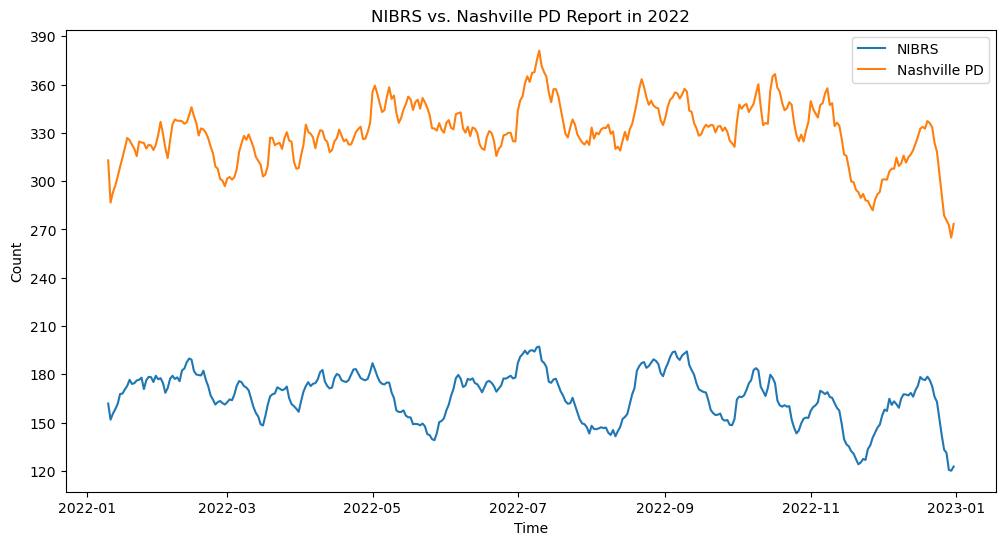

In [51]:
from matplotlib.ticker import MaxNLocator

# Plot report frequencies of NIBRS vs. Nashville PD in 2022 (rolling average)
plt.figure(figsize=(12, 6))
plt.plot(nibrs_count['Time'], nibrs_count['Count'].rolling(10).mean(), label='NIBRS')
plt.plot(npd_count['Time'], npd_count['Count'].rolling(10).mean(), label='Nashville PD')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('NIBRS vs. Nashville PD Report in 2022')
plt.legend()
plt.savefig('nashville_volume.png', bbox_inches='tight')
plt.show()

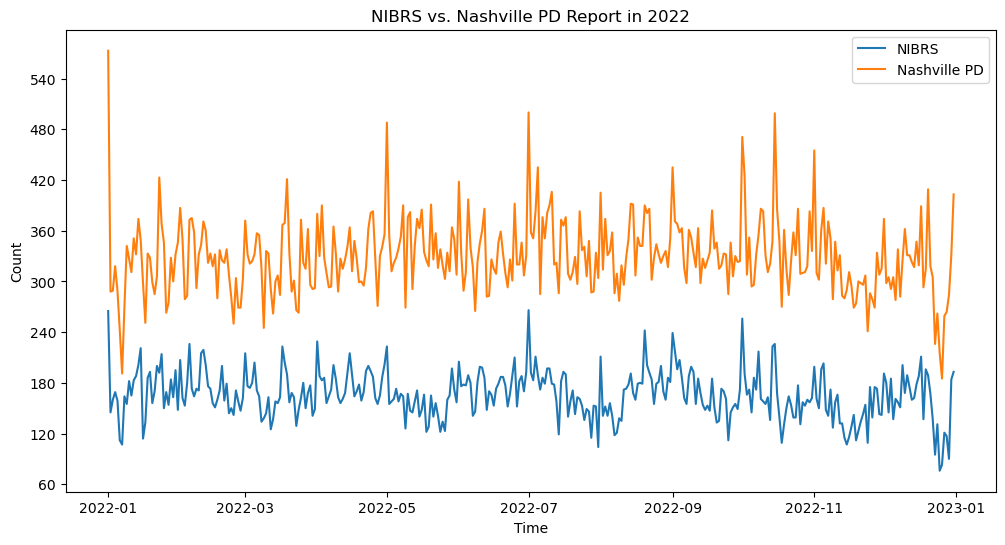

In [52]:
# Plot report frequencies of NIBRS vs. Boston PD in 2022
plt.figure(figsize=(12, 6))
plt.plot(nibrs_count['Time'], nibrs_count['Count'], label='NIBRS')
plt.plot(npd_count['Time'], npd_count['Count'], label='Nashville PD')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('NIBRS vs. Nashville PD Report in 2022')
plt.legend()
plt.show()

In [53]:
# Get correlations
combined_counts = nibrs_count.rename(
    columns={'Count': 'NIBRS'}
).merge(
    npd_count.rename(
        columns={'Count': 'Nashville'}
    )
).set_index('Time')

combined_counts.corr()

,NIBRS,Nashville
NIBRS,1.000000,0.674062
Nashville,0.674062,1.000000


In [54]:
# Get a list of unique offenses in Nashville
unique_nashville_offenses = nashville_incident['Offense_Description'].dropna().str.lower().unique().tolist()
unique_nashville_offenses

['overdose',
 'assault, domestic, bodily injury 2nd offense',
 'simple asslt',
 'assault- fear of bodily injury',
 'damage prop - private',
 'simple asslt - strangulation (no loss of consciousness)',
 'shoplifting',
 'burglary- motor vehicle',
 'imitation controlled substance - use or possess',
 'transport',
 'death natural',
 'larc - from bldg',
 'accidental injury',
 'burgl - forced entry-nonresid',
 'weapon offense, criminal attempt',
 'lost property',
 'burglary- aggravated',
 'assault, aggravated - deadly weapon - reckless',
 'police inquiry',
 'suicide',
 'recovery, stolen property',
 'burgl - no forced entry-nonresid',
 'found property',
 'burglary - motor vehicle',
 'assault, aggravated - deadly weapon - int/kn',
 'vehicle theft',
 'theft of property-$1,000 or less',
 'larc - parts from veh',
 'robbery',
 'intentional aggravated assault',
 'assault, nurse, offensive contact',
 'arson - resid',
 'burglary - aggravated - acting in concert',
 'fraud by wire',
 'forgery->$1,000 but

In [55]:
# Count the total number of unique offenses in Nashville
len(unique_nashville_offenses)

387

In [56]:
# Search the UCR offense codes in the NIBRS codebook
codebook = pd.read_excel(CODEBOOK_PATH, sheet_name='Incident Extract').ffill()
codebook = codebook[codebook['Variable Name'] == 'V20061']

# Create the mapping dictionary
mapper = dict(zip(codebook['Value'], codebook['Value Label']))
mapper

{91: 'Murder/Nonnegligent Manslaughter',
 92: 'Negligent Manslaughter',
 93: 'Justifiable Homicide',
 100: 'Kidnaping/Abduction',
 111: 'Rape',
 112: 'Sodomy',
 113: 'Sexual Assault With An Object',
 114: 'Fondling (Indecent Liberties/Child Molesting)',
 120: 'Robbery',
 131: 'Aggravated Assault',
 132: 'Simple Assault',
 133: 'Intimidation',
 200: 'Arson',
 210: 'Extortion/Blackmail',
 220: 'Burglary/Breaking and Entering',
 231: 'Pocket-picking',
 232: 'Purse-snatching',
 233: 'Shoplifting',
 234: 'Theft From Building',
 235: 'Theft From Coin-Operated Machine or Device',
 236: 'Theft From Motor Vehicle',
 237: 'Theft of Motor Vehicle Parts/Accessories',
 238: 'All Other Larceny',
 240: 'Motor Vehicle Theft',
 250: 'Counterfeiting/Forgery',
 261: 'False Pretenses/Swindle/Confidence Game',
 262: 'Credit Card/Automatic Teller Machine Fraud',
 263: 'Impersonation',
 264: 'Welfare Fraud',
 265: 'Wire Fraud',
 266: 'Identity Theft',
 267: 'Hacking/Computer Invasion',
 270: 'Embezzlement',


In [57]:
# Replace the values in 'V20061-UCR OFFENSE CODE - 1' with the UCR descriptions
nashville_incident_nibrs['V20061-UCR OFFENSE CODE - 1'] = nashville_incident_nibrs['V20061-UCR OFFENSE CODE - 1'].map(mapper)
unique_nibrs_offenses = nashville_incident_nibrs['V20061-UCR OFFENSE CODE - 1'].dropna().str.lower().unique().tolist()
unique_nibrs_offenses

['all other larceny',
 'credit card/automatic teller machine fraud',
 'theft from motor vehicle',
 'theft of motor vehicle parts/accessories',
 'simple assault',
 'intimidation',
 'destruction/damage/vandalism of property',
 'motor vehicle theft',
 'false pretenses/swindle/confidence game',
 'theft from coin-operated machine or device',
 'burglary/breaking and entering',
 'impersonation',
 'counterfeiting/forgery',
 'theft from building',
 'wire fraud',
 'aggravated assault',
 'fondling (indecent liberties/child molesting)',
 'drug/narcotic violations',
 'robbery',
 'embezzlement',
 'statutory rape',
 'sodomy',
 'rape',
 'shoplifting',
 'weapon law violations',
 'welfare fraud',
 'pornography/obscene material',
 'pocket-picking',
 'extortion/blackmail',
 'sexual assault with an object',
 'human trafficking- commercial sex acts',
 'kidnaping/abduction',
 'arson',
 'drug equipment violations',
 'hacking/computer invasion',
 'murder/nonnegligent manslaughter',
 'purse-snatching',
 'purcha

In [58]:
from sentence_transformers import SentenceTransformer

# Use a transformer model to embed texts as matrices
st_model = SentenceTransformer(model_name_or_path='sentence-transformers/all-MiniLM-L6-v2')

nashville_embeddings = st_model.encode(unique_nashville_offenses)
nibrs_embeddings = st_model.encode(unique_nibrs_offenses)

In [59]:
from sklearn.metrics.pairwise import cosine_similarity

# Use cosine similarity to compare offense descriptions
embedding_array = cosine_similarity(
    nibrs_embeddings,
    nashville_embeddings,
)

sim_df = pl.DataFrame(
    embedding_array,
    schema=unique_nashville_offenses,
).with_columns(
    pl.Series(name='NIBRS Descriptions', values=unique_nibrs_offenses)
).melt(
    id_vars='NIBRS Descriptions',
    variable_name='Nashville Descriptions',
    value_name='Cosine Similarity'
).sort(
    'Cosine Similarity',
    descending=True,
)

sim_df

NIBRS Descriptions,Nashville Descriptions,Cosine Similarity
str,str,f32
"""robbery""","""robbery""",1.0
"""shoplifting""","""shoplifting""",1.0
"""prostitution""","""prostitution""",0.999999
"""justifiable homicide""","""homicide, justifiable""",0.970106
"""wire fraud""","""fraud by wire""",0.964936
…,…,…
"""assisting or promoting prostit…","""contempt - violation of protec…",-0.087621
"""theft from coin-operated machi…","""aggrav asslt - family-stgarm""",-0.087997
"""wire fraud""","""open container viol.""",-0.091588


In [60]:
# Create a dictionary with Nashville descriptions as keys and NIBRS descriptions as values
# Group by 'Nashville Descriptions' and take the first row for each group (highest similarity)
nashville_nibrs_dict = sim_df.group_by(
    'Nashville Descriptions',
    maintain_order=True,
).agg(
    pl.col('NIBRS Descriptions').first()
).to_pandas().set_index(
    'Nashville Descriptions'
).to_dict()['NIBRS Descriptions']

# Display the resulting dictionary
nashville_nibrs_dict

{'robbery': 'robbery',
 'shoplifting': 'shoplifting',
 'prostitution': 'prostitution',
 'homicide, justifiable': 'justifiable homicide',
 'fraud by wire': 'wire fraud',
 'vehicle theft': 'motor vehicle theft',
 'criminal impersonation': 'impersonation',
 'stolen property': 'stolen property offenses',
 'extortion': 'extortion/blackmail',
 'embezzlement, criminal attempt': 'embezzlement',
 'prostitution- promoting': 'assisting or promoting prostitution',
 'arson - business': 'arson',
 'intentional aggravated assault': 'aggravated assault',
 'assault': 'simple assault',
 'assault, vehicular, aggravated': 'aggravated assault',
 'prostitution, criminal attempt': 'prostitution',
 'recovery, stolen property': 'stolen property offenses',
 'assault, aggravated - strangulation - int/kn': 'aggravated assault',
 'assault, aggravated - strangulation-int/kn': 'aggravated assault',
 'assault, aggravated - death - int/kn': 'aggravated assault',
 'prostitution - patronizing': 'prostitution',
 'prostitu

In [61]:
# Output the dictionary to a JSON file
with open('nashville_NIBRS_similarity.json', 'w') as fout:
    json.dump(nashville_nibrs_dict, fout, indent=4)

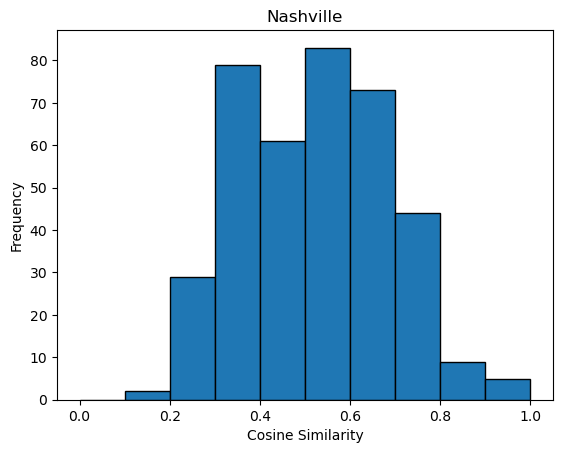

In [62]:
# Visualize the distribution of offense descriptions' cosine similarity
hist_data = sim_df.group_by(
    'Nashville Descriptions',
    maintain_order=True,
).agg(
    pl.col('NIBRS Descriptions').first(),
    pl.col('Cosine Similarity').first()
).to_pandas()['Cosine Similarity']

# Plotting the histogram
hist_data.plot(
    kind='hist',
    bins=np.arange(0, 1.01, 0.1),
    edgecolor='k'
)

plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Nashville')
plt.savefig('nashville_cos_sim.png', bbox_inches='tight')
plt.show()

In [63]:
# Count unique NIBRS offense codes mentioned in Nashville's open data
nashville_incident['Offense_NIBRS'].nunique()

66

In [64]:
# Create a reversed mapper
reversed_mapper = {value.lower(): key for key, value in mapper.items()}

# Map the offense descriptions in Nashville to the predicted UCR codes
predicted_labels = pd.Series(
    nashville_incident['Offense_Description'].dropna().str.lower()
).map(nashville_nibrs_dict).map(reversed_mapper)

# Initialize an empty dictionary to hold the lists of predicted UCR codes
true_vs_predicted_UCR = {}

# Populate the dictionary with lists of predicted UCR codes
for true_value, predicted_value in zip(nashville_incident['Offense_NIBRS'], predicted_labels):
    if true_value in true_vs_predicted_UCR:
        true_vs_predicted_UCR[true_value].append(predicted_value)
    else:
        true_vs_predicted_UCR[true_value] = [predicted_value]

# Get only the unique values from the lists
true_vs_predicted_UCR = {key: list(set(value)) for key, value in true_vs_predicted_UCR.items()}

true_vs_predicted_UCR

{'760': [351],
 '13B': [113, 131, 132, 93],
 '13C': [200, 132, 133],
 '290': [280, 393, 290, 720],
 '23C': [120, 233, 237],
 '23F': [240],
 '35A': [352, 641, 290, 132, 263, 232, 233, 520, 238, 401, 403, 280, 351],
 '740': [232, 233],
 '685': [93],
 '23D': [238, 262],
 '620': [131],
 '220': [120, 131, 220],
 '520': [520, 290, 352],
 '810': [280],
 '13A': [520, 131, 132],
 '690': [111],
 '780': [280],
 '715': [280],
 '240': [240, 236],
 '23H': [263, 232, 231, 265, 267, 238, 280],
 '23G': [237],
 '120': [120, 131],
 '200': [200],
 '26E': [265, 234],
 '250': [120, 250, 220],
 '26B': [262],
 '23A': [120],
 '270': [265, 270],
 '90J': [280, 240, 131],
 '35B': [352],
 '26C': [240, 263],
 '26A': [352, 290, 261, 264, 265, 234, 393, 280],
 '735': [131],
 '90F': [280, 114, 720],
 '90Z': [352, 131, 132, 133, 520, 393, 236, 111, 720, 240, 370, 402, 92, 351],
 '100': [100],
 '680': [93],
 '210': [120, 264, 210],
 '695': [200],
 '850': [352, 132],
 '90A': [250, 262],
 '13D': [280, 113, 131, 93],
 '90C

In [65]:
# Output the dictionary to a JSON file
with open('nashville_NIBRS_UCR.json', 'w') as fout:
    json.dump(true_vs_predicted_UCR, fout, indent=4)